# PBO learnt on several iterations and one weigth one the chain walk environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax

# keys
seed = 10
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
n_states = 10
n_actions = 2
n_repetitions = 10
sucess_probability = 0.9
gamma = 0.9

# Weights collection
n_weights = 1
filtering_weights = True

# Trainings
max_bellman_iterations = 200
add_infinity = False
shuffle_freq = 20

## Linear PBO
max_steps = 10
batch_size_samples = n_states // 2
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.001, "duration": max_steps}

## Q-learning
learning_rate_q = {"first": 1, "last": 1, "duration": max_steps}

# Visualisation
plot_freq = 5
sleeping_time = 0

## Define environment

In [2]:
from pbo.environment.chain_walk import ChainWalkEnv

states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = (np.arange(n_states + 1 + 1) - 0.5)[:-1]
actions_boxes = (np.arange(n_actions + 1 + 1) - 0.5)[:-1]

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_states * n_actions * n_repetitions
replay_buffer = ReplayBuffer()

for state in states:
    for action in actions:
        # Need to repeat the samples to capture the randomness
        for _ in range(n_repetitions):
            env.reset(jnp.array([state]))
            next_state, reward, _, _ = env.step(jnp.array([action]))

            replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

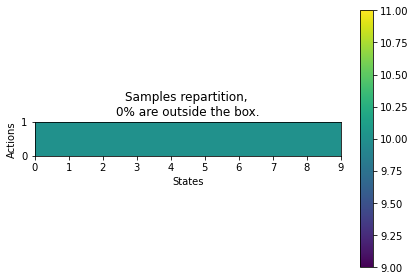

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, states_boxes, actions_boxes)
samples_visu_mesh = StateActionMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)

## Optimal Q function

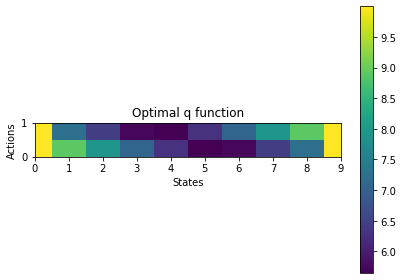

In [5]:
optimal_q = env.optimal_Q_mesh()

q_visu_mesh = StateActionMesh(states, actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.learnable_q import TableQ


q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions
)

## Collect weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    if not filtering_weights or weights.max() < 1 / (1 - gamma):
        weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train Q with Fitted-Q

In [8]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate)
q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=learning_rate_q,
)

q.params = q.to_params(weights_buffer.weights[0])

# For visualization
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}

training_losses_q_uniform = []
validation_losses_q_uniform = []

for k in tqdm(np.arange(max_bellman_iterations)):
    params_target = q.params

    if (k + 1) % shuffle_freq == 0 or k == 0:
        data_loader_samples.shuffle()

    for step in range(max_steps):
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, _ = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            break          

    training_losses_q_uniform.append(q.loss(q.params, params_target, full_batch, ord=1))
    validation_losses_q_uniform.append(jnp.abs(optimal_q.flatten() - q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions).flatten()).mean())

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, n_samples, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate)
q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=learning_rate_q,
)

q.params = q.to_params(weights_buffer.weights[0])

# For visualization
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}

training_losses_q_geom = []
validation_losses_q_geom = []
c_samples = batch_size_samples * max_bellman_iterations / (np.sum([k for k in range(1, max_bellman_iterations + 1)])) 


for k in tqdm(np.arange(max_bellman_iterations)):
    params_target = q.params

    if (k + 1) % shuffle_freq == 0 or k == 0:
        data_loader_samples.shuffle()
    n_samples_iteration = np.maximum(int(np.round(c_samples * (k + 1))), 1)

    for step in range(max_steps):
        batch_samples = {
            "state": data_loader_samples[0]["state"][: n_samples_iteration],
            "action": data_loader_samples[0]["action"][: n_samples_iteration],
            "reward": data_loader_samples[0]["reward"][: n_samples_iteration],
            "next_state": data_loader_samples[0]["next_state"][: n_samples_iteration],
        }
        q.params, q.optimizer_state, _ = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)            

    training_losses_q_geom.append(q.loss(q.params, params_target, full_batch, ord=1))
    validation_losses_q_geom.append(jnp.abs(optimal_q.flatten() - q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions).flatten()).mean())

  0%|          | 0/200 [00:00<?, ?it/s]

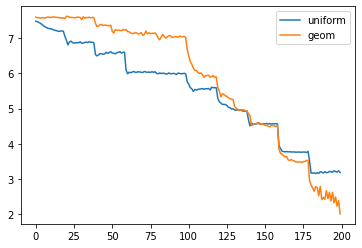

In [10]:
import matplotlib.pyplot as plt 

plt.plot(validation_losses_q_uniform, label="uniform")
plt.plot(validation_losses_q_geom, label="geom")

plt.legend()

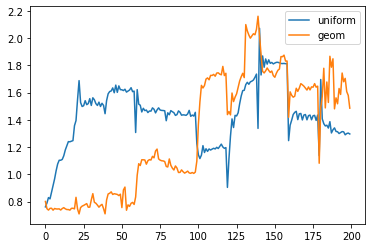

In [11]:
plt.plot(training_losses_q_uniform, label="uniform")
plt.plot(training_losses_q_geom, label="geom")

plt.legend()

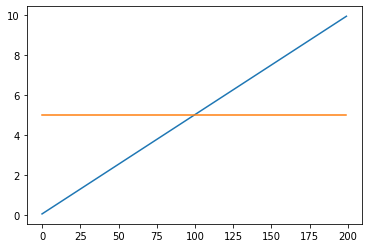

In [12]:
plt.plot([c_samples * k for k in range(1, max_bellman_iterations + 1)])
plt.plot(np.ones(max_bellman_iterations) * batch_size_samples)

## Train PBO

In [13]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate)

# For visualization
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}

training_losses_uniform = []
validation_losses_uniform = []

for k in tqdm(np.arange(max_bellman_iterations)):
    importance_iteration = jnp.zeros(max_bellman_iterations + 1)
    importance_iteration = importance_iteration.at[k].set(1)
    params_target = pbo.params

    if (k + 1) % shuffle_freq == 0 or k == 0:
        data_loader_samples.shuffle()

    for step in range(max_steps):
        for batch_samples in data_loader_samples:
            pbo.params, pbo.optimizer_state, _ = pbo.learn_on_batch(
                pbo.params, params_target, pbo.optimizer_state, data_loader_weights.weights, batch_samples, importance_iteration
            )
            break 

    batch_iterated_weights = data_loader_weights.weights.copy()
    for _ in range(k):
        batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)

    training_losses_uniform.append(pbo.loss(pbo.params, params_target, data_loader_weights.weights, full_batch, importance_iteration, ord=1))
    validation_losses_uniform.append(jnp.abs(optimal_q.flatten() - q.discretize(batch_iterated_weights, states, actions).flatten()).mean())

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
from tqdm.notebook import tqdm


data_loader_samples = SampleDataLoader(replay_buffer, n_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate)

# For visualization
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}

training_losses_geom = []
validation_losses_geom = []

for k in tqdm(np.arange(max_bellman_iterations)):
    importance_iteration = jnp.zeros(max_bellman_iterations + 1)
    importance_iteration = importance_iteration.at[k].set(1)

    params_target = pbo.params

    if (k + 1) % shuffle_freq == 0 or k == 0:
        data_loader_samples.shuffle()
    n_samples_iteration = np.maximum(int(np.round(c_samples * (k + 1))), 1)

    for step in range(max_steps):
        batch_samples = {
            "state": data_loader_samples[0]["state"][: n_samples_iteration],
            "action": data_loader_samples[0]["action"][: n_samples_iteration],
            "reward": data_loader_samples[0]["reward"][: n_samples_iteration],
            "next_state": data_loader_samples[0]["next_state"][: n_samples_iteration],
        }
        pbo.params, pbo.optimizer_state, _ = pbo.learn_on_batch(pbo.params, params_target, pbo.optimizer_state, data_loader_weights.weights, batch_samples, importance_iteration)            
                
    batch_iterated_weights = data_loader_weights.weights.copy()
    for _ in range(k):
        batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)

    training_losses_geom.append(pbo.loss(pbo.params, params_target, data_loader_weights.weights, full_batch, importance_iteration, ord=1))
    validation_losses_geom.append(jnp.abs(optimal_q.flatten() - q.discretize(batch_iterated_weights, states, actions).flatten()).mean())

  0%|          | 0/200 [00:00<?, ?it/s]

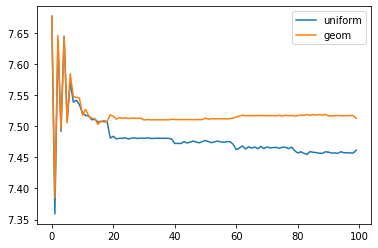

In [23]:
import matplotlib.pyplot as plt 

plt.plot(validation_losses_uniform[:100], label="uniform")
plt.plot(validation_losses_geom[:100], label="geom")

plt.legend()


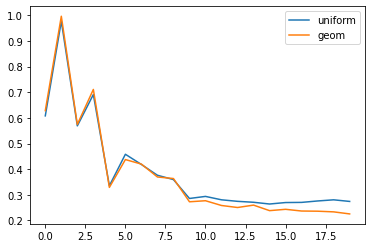

In [22]:
plt.plot(training_losses_uniform[:20], label="uniform")
plt.plot(training_losses_geom[:20], label="geom")

plt.legend()